# Plot Maps of ROH sharing.
Use basemap to create nice visualizations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os  # For Saving to Folder
import pandas as pd
from scipy.stats import binned_statistic  # For Binning

import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

import socket
import os as os
import sys as sys
import multiprocessing as mp

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

### Additional Imports
sys.path.append("./PackagesSupport/")
from sqrt_scale import SquareRootScale # Import Matplotlib sqrt scale

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Important Functions
For plotting ROH maps in Basemap as well as modifying/extracting the results dataframes

In [2]:
def plot_continent(df, crs=[30, 60, -10, 40], s=40, vrange=[0, 400], cmap="hot_r", 
                   fs_label=14, figsize=(12,11),
                   states=True, annotate=False, fs_labels=14, ew=0.5, y_off=1, title="", 
                   vrange_a=[], mm=3.1,
                   savepath="", dpi=300, cm_min=4): 
    """Plot a continent, based on coordinates in df
    df: Pandas Datframe with lat lon column
    crs: [4], Corners of plot (lat and then lon)
    vrange: Normalization range for color [cM]
    shiftlong: Add to longitude (in cases for map on South America)
    vrange_a: The Age Range to Plot"""
    col_cont, col_lake = "#d9d9d9", "#d9d9d9"  # Colors for Map
    fs = 18
    lon, lat = df["lon"].values, df["lat"].values
    
    colors = df[f"sum_roh>{cm_min}"]  ### Plot based on sum roh
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[12,1]) # Third axis is just to get space!
    ax = plt.subplot(gs[0]) # The upper subplot
    ax1 = plt.subplot(gs[1]) # The lower one
    
    gs.update(wspace=0.0, hspace=0.02) # set the spacing between axes.

    m = Basemap(projection='merc', llcrnrlat=crs[0], urcrnrlat=crs[1],\
                llcrnrlon=crs[2], urcrnrlon=crs[3], resolution='i', ax=ax)  # mill

    m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
    #m.etopo(scale=0.5, alpha=0.4)  # Topological Map
    m.drawcoastlines(color='gray', zorder=0)
    m.drawcountries(color="dimgray")
    
    if states==True:
        m.drawstates()
        
    ### Convert lat/lon to the plot coordinates
    #lon = m.shiftdata(lon, lon_0=0) # Shift Longitudes so that plotted (-180,180 around lon0)
    coords = np.array([m(lon[i],lat[i]) for i in range(len(lon))])
    x,y = np.array(coords[:,0]), np.array(coords[:,1])

    ax.scatter(x, y, c=colors, ec="k", s=s, lw=ew, cmap=cmap, norm=norm, zorder=3)
    
    if len(vrange_a)>0:
        cmap_a = cm.get_cmap("binary")    # viridis_r COlor Map for the Agee
        norm_a = plt.Normalize(vrange_a[0], vrange_a[1])
        ax.scatter(x, y, c=df["age"].values, ec="k", s=s*mm, lw=ew, zorder=2, cmap=cmap_a, norm=norm_a)
        
        sm = plt.cm.ScalarMappable(cmap=cmap_a, norm=norm_a)
        sm.set_array([])
        #cax = fig.add_axes([0.05, 0.05, 0.3, 0.4]) # Make internal Axis
        divider = make_axes_locatable(ax)  # So partof Axis can be split off
        cax = divider.append_axes('right', size='6%', pad=0.07)
        fig.colorbar(sm, cax=cax, orientation='vertical')
        cax.set_ylabel('Age BP [y]', fontsize=fs_label, labelpad=0, rotation=270)
    
    if annotate:
        for i, txt in enumerate(df["clst"]):
            ax.text(x[i], y[i]+y_off, txt, fontsize=fs_labels, zorder=1, ha="center", clip_on=True)
    
    if len(title)>0:
        ax.set_title(title, fontsize=fs_labels)
    
    # Do the colorbar
    plot_colorbar(ax1, fs_label=fs_label, cmap=cmap, norm=norm)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    plt.show()
    
    
def plot_colorbar(ax1, fs_label, cmap, norm, tot_len=3539.39):
    """Code for plotting the colorbar"""
    cb1 = clb.ColorbarBase(ax1, cmap=cmap,
                           norm=norm, orientation='horizontal') # For the /1e3 format
    cb1.ax.tick_params(axis='x', direction='in', labelsize=fs_label)
    ax1.set_xlabel('Sum Indiviual ROH >4cM [cM]', fontsize=fs_label, rotation=0, labelpad=10)
    
    ### Set the Ticks for various degrees of Relatives:
    ticks = [tot_len/16, tot_len/64]
    labels = ["Full 1st Cousin", "Full 2nd Cousin"]
    
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(labels)
    ax2.tick_params(axis='x', direction='in', labelsize=fs_label, pad=-fs_label*1.5)

    
def prepare_coordinates_square(lat, lon, ofst_lat=0.1, ofst_lon=0.2):
    """Prepare and return coordinates in a square"""
    assert(len(lat)>0)   # Sanity Check
    n = len(lat)
    ints = np.array(range(n))
    r = np.ceil(np.sqrt(n)) # What's the maximum width
    hor = ints % r
    ver = np.floor(ints / r)
    
    # Apply the Correction
    lon_new = lon + hor * ofst_lon - (r-1)/2 * ofst_lon
    lat_new = lat - ver * ofst_lat + (r-1)/2 * ofst_lat
    
    return lat_new, lon_new

def prepare_coordinates_df(df, ofst_lat=0.1, ofst_lon=0.2):
    """Create coordinates in a new Dataframe, based on matching groups of coordinates"""
    gp = df.groupby(['lat','lon'])
    gp_idcs = list(gp.indices.values())  # Get list of list of Indices
    df_plot = df.copy(deep=True)  # Make a Deep Copy for modifying GPS

    ### Modify all Lat/Lon Indices
    for i, idcs in enumerate(gp_idcs[:]):  # Go over all Group Indices
        x = df.iloc[idcs][["lat", "lon"]]
        lat, lon =  df.iloc[idcs]["lat"], df.iloc[idcs]["lon"]
        lat, lon = prepare_coordinates_square(lat.values, lon.values, 
                                              ofst_lat=ofst_lat, ofst_lon=ofst_lon)

        df_plot["lat"].iloc[idcs] = lat
        df_plot["lon"].iloc[idcs] = lon
    return df_plot

In [3]:
def extract_df_geo(df, lat0, lat1, lon0, lon1):
    """Extract Dataframe df from Sub Data frame based on coordinates
    lat0,lat1: Min and Max Lat. Equ. for lon0,lon1"""
    lat_okay = (df["lat"]>lat0) & (df["lat"]<lat1)
    lon_okay = (df["lon"]>lon0) & (df["lon"]<lon1)
    df_s = df[lat_okay & lon_okay]
    return df_s

def extract_df_age(df, age0, age1=1e6):
    """Extract Dataframe based on age.
    df: Input Dataframe; age0 and age1 min and max age"""
    age_okay = (df["age"]>=age0) & (df["age"]<=age1)
    df = df[age_okay]
    return df

def clean_roh_df(df1, age_cutoff=15000, iids_del = ["Loschbour_snpAD.DG", "I0001"]):
    """Clean a ROH Dataframe to only values with geographic data (and below age).
    Also remove some duplicate samples based on iid"""
    df1 = df1[~np.isnan(df1["lat"])]
    df1 = df1[~np.isnan(df1["lon"])]
    print(f"Filtered to {len(df1)} Individuals with existing Lat/Lon values")
    df1 = df1[df1["age"]<age_cutoff]
    print(f"Filtered to {len(df1)} Individuals with Age < {age_cutoff}")
    
    df1.loc[df1["iid"]=="Aconcagua.SG", "lat"] = -32.65  # Flip Wrong Latitude (32.64 is in Atlantic)
    
    del_idx = df1["iid"].isin(iids_del)
    df1 = df1[~del_idx]
    print(f"Filtered to {len(df1)} unique Individuals")
    return df1

### Load Data
1. full meta_df and 
2. HO results meta

In [5]:
### Load the relevant Data
meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
df_meta = pd.read_csv(meta_path)
df_ho = df_meta[df_meta["study"]=="Lazaridis et al. 2014"]

In [5]:
### Load HAPSBURG results
ho_results_path = "./Empirical/HO/CombinedROH/combinedroh.csv"
df_roh = pd.read_csv(ho_results_path, sep='\t')

## World Wide Plot of all HO samples

In [4]:
def plot_ho_geography(df_roh, fs = 18, figsize=(18,12)):
    """Do a Map of HO samples across the world"""
    lat=df_roh["lat"].values
    lon=df_roh["lon"].values

    fig = plt.figure(figsize=figsize)
    ax=fig.add_axes([0.1,0.1,0.8,0.8])

    #m = Basemap(projection='cyl',llcrnrlat=-60,urcrnrlat=85, 
    #                llcrnrlon=-180,urcrnrlon=180,resolution='c')

    m = Basemap(projection='moll', lat_0=0, lon_0=0)

    m.drawcoastlines()
    #m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1], fontsize=8)
    #m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1], rotation=45, fontsize=8)
    #m.etopo(scale=0.5, alpha=0.4)  # if topological map
    m.drawcoastlines(color='gray', zorder=0)
    m.drawcountries(color="dimgray")
    #m.drawstates()

    plt.title(f"{len(lon)} HO Samples World Wide", fontsize=fs)
    m.scatter(lon, lat, latlon=True, c="magenta", ec="k", s=20, lw=0.5) #cmap=cmap0, norm=norm0
    #          c=df_plot["ages"].values, alpha=0.8, s=25, edgecolors='k', linewidths=0.3)
    #plt.colorbar(label="Age [ky BP]", shrink=0.5)
    #fig.savefig("", dpi=200, bbox_inches = 'tight', pad_inches = 0)
    #plt.close(fig)
    plt.show()

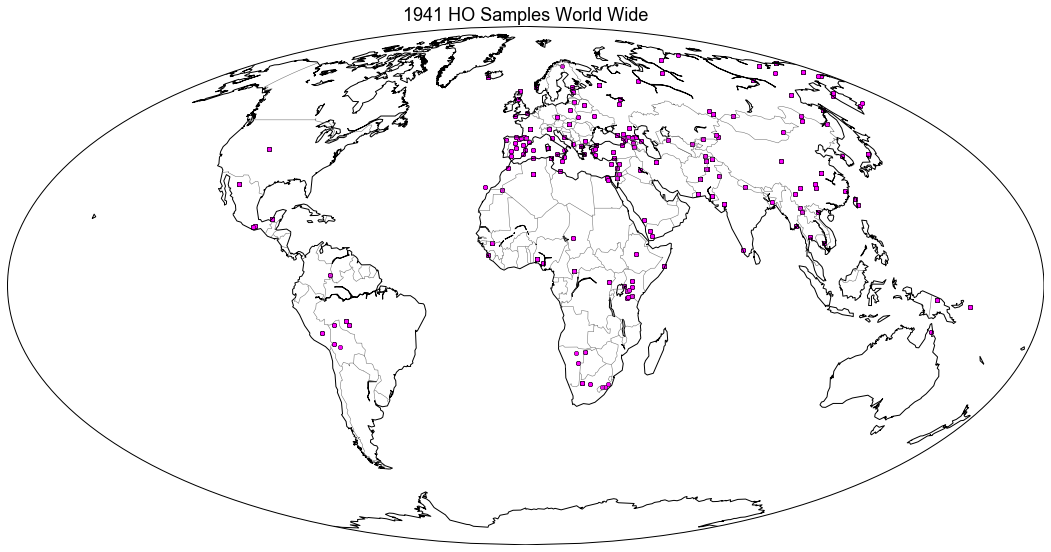

In [26]:
plot_ho_geography(df_roh)

### Plot Europe with splitting up samples

Saved to ./figures/manuscript/supplement/HO_ROH/europe.pdf


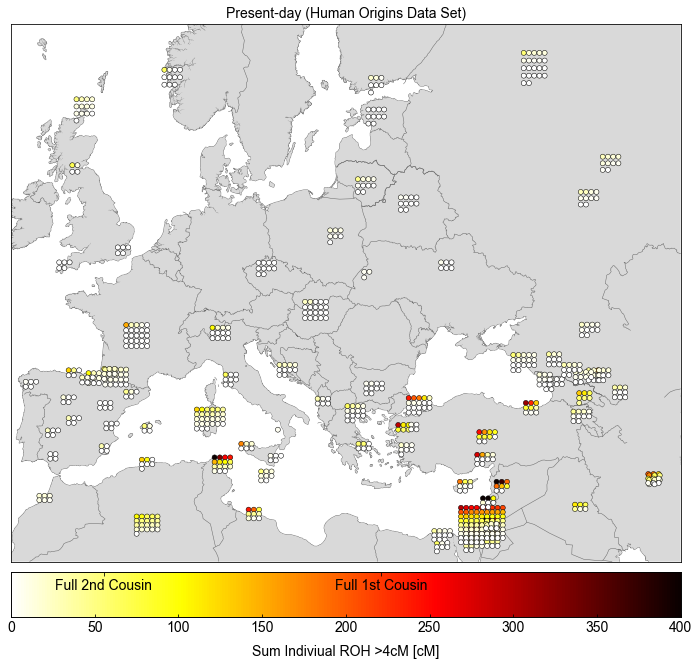

In [21]:
#df_plot = prepare_coordinates_df(df_roh, ofst_lat=0.35, ofst_lon=0.5)
plot_continent(df_plot, crs=[29, 63, -10, 54], dpi=300, s=25, title="Present-day (Human Origins Data Set)", 
               savepath="./figures/manuscript/supplement/HO_ROH/europe.pdf")

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Saved to ./figures/manuscript/supplement/HO_ROH/asia.pdf


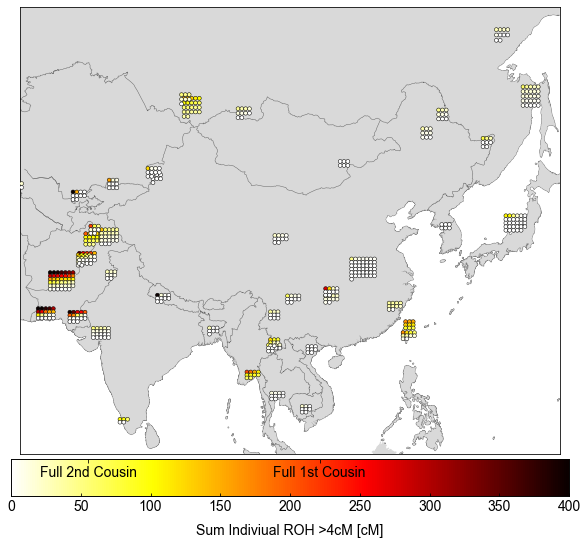

In [37]:
### Do the same for Asia
df_plot = prepare_coordinates_df(df_roh, ofst_lat=0.45, ofst_lon=0.6)
plot_continent(df_plot, crs=[5, 60, 60, 145], s=15, figsize=(10,9),
              savepath="./figures/manuscript/supplement/HO_ROH/asia.pdf")

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Saved to ./figures/manuscript/supplement/HO_ROH/america.pdf


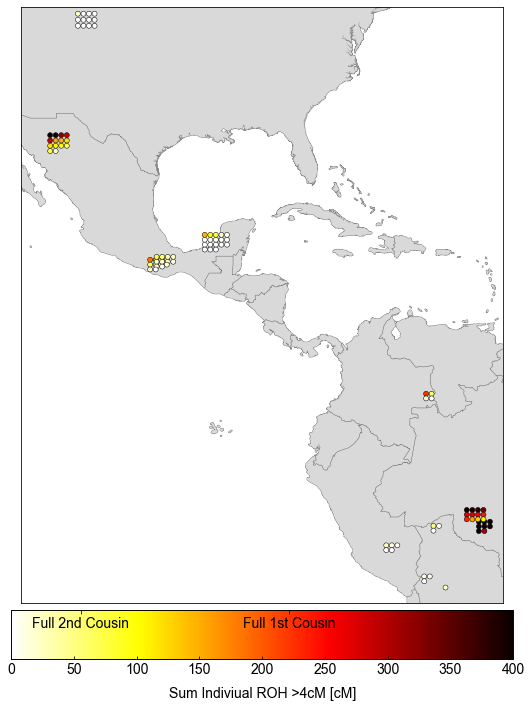

In [6]:
df_plot = prepare_coordinates_df(df_roh, ofst_lat=0.5, ofst_lon=0.6)
plot_continent(df_plot, crs=[-19, 41, -112, -60], s=25, figsize=(9,12), states=False,
               savepath="./figures/manuscript/supplement/HO_ROH/america.pdf")

### Plot Africa

# Plot ROH from Reich Sample (ancients)
Need Plotting functino and Imports from above

In [4]:
### Then apply some filters
age_cutoff=15000


### First load the Data
df1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", '\t')
print(f"Loaded {len(df1)} Individuals")

df1 = df1[~np.isnan(df1["lat"])]
df1 = df1[~np.isnan(df1["lon"])]
print(f"Filtered to {len(df1)} Individuals with existing Lat/Lon values")
df1 = df1[df1["age"]<age_cutoff]
print(f"Filtered to {len(df1)} Individuals with Age < {age_cutoff}")
#df_plot = prepare_coordinates_df(df1, ofst_lat=0.3, ofst_lon=0.45)

Loaded 1098 Individuals
Filtered to 988 Individuals with existing Lat/Lon values
Filtered to 966 Individuals with Age < 15000


In [5]:
df_plot = prepare_coordinates_df(df1, ofst_lat=0.8, ofst_lon=1.0)  # Spacing adequate for South America

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


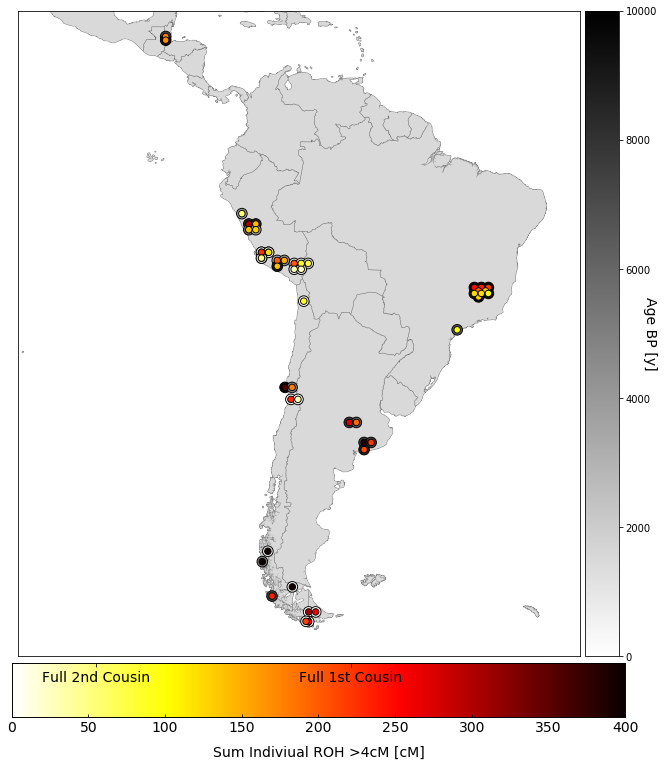

In [39]:
plot_continent(df_plot, crs=[-58, 20, -110, -30], s=42, figsize=(11,13), states=False,
               annotate=False, fs_labels=8, ew=0.9, y_off=1e5, vrange_a=[0,10000], mm=2.7)

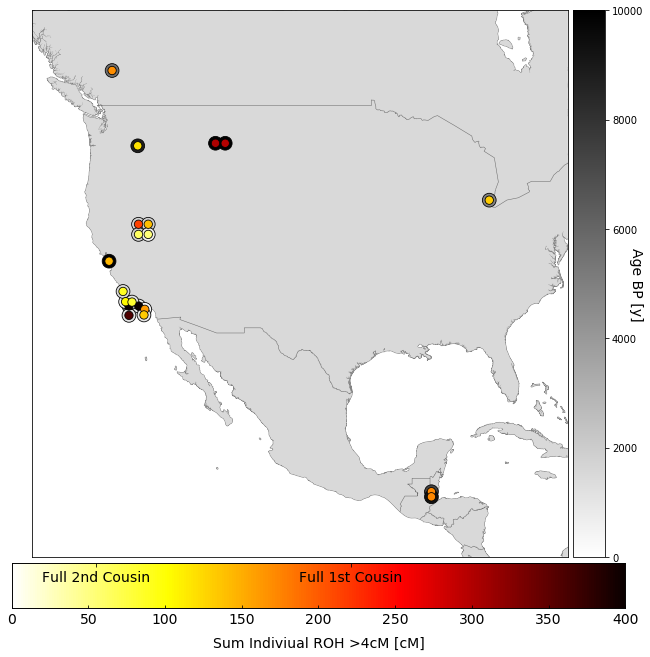

In [42]:
plot_continent(df_plot, crs=[10, 55, -130, -75], s=70, figsize=(11,11), states=False,
               annotate=False, fs_labels=8, ew=0.8, vrange_a=[0,10000], mm=2.7)

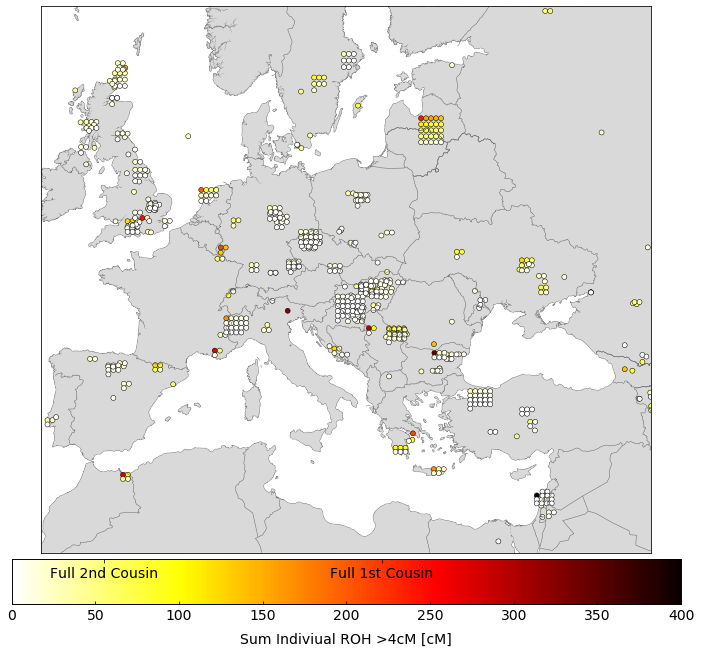

In [12]:
#df_plot = prepare_coordinates_df(df1, ofst_lat=0.3, ofst_lon=0.45)
plot_continent(df_plot, crs=[29, 62, -10, 45], s=25)
#plot_continent(df_plot, crs=[30, 40, 30, 40], s=30)

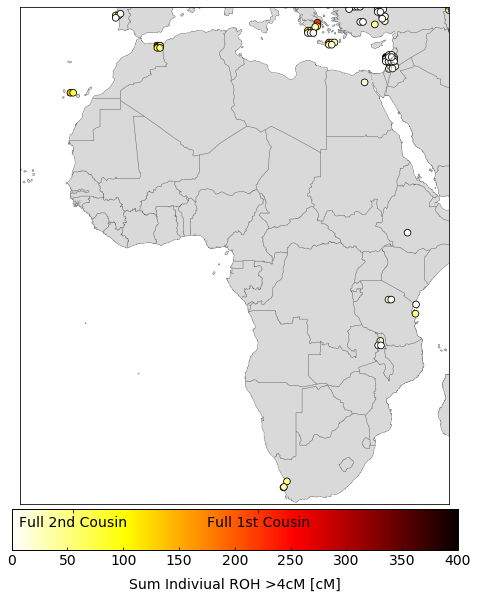

In [25]:
plot_continent(df_plot, crs=[-35, 40, -25, 45], s=45, figsize=(8,10), ew=0.8)

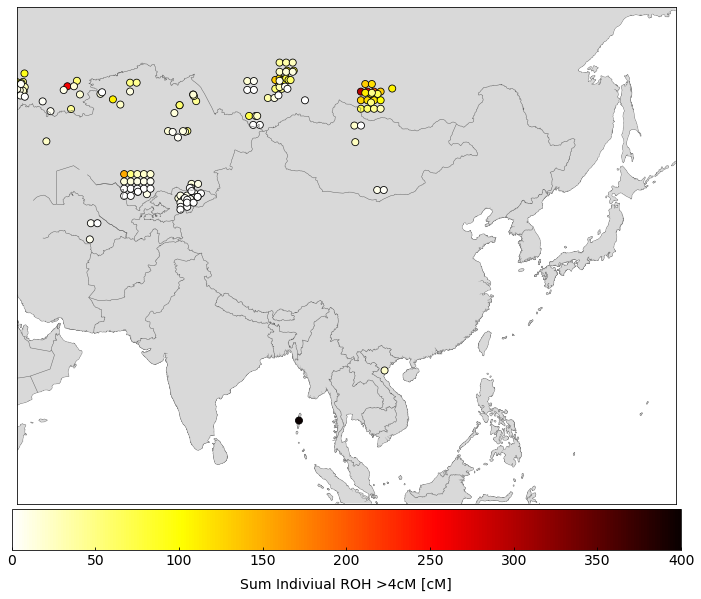

In [23]:
plot_continent(df_plot, crs=[0, 60, 50, 150], s=50, figsize=(12,10),
               annotate=False, fs_labels=14, ew=0.8)

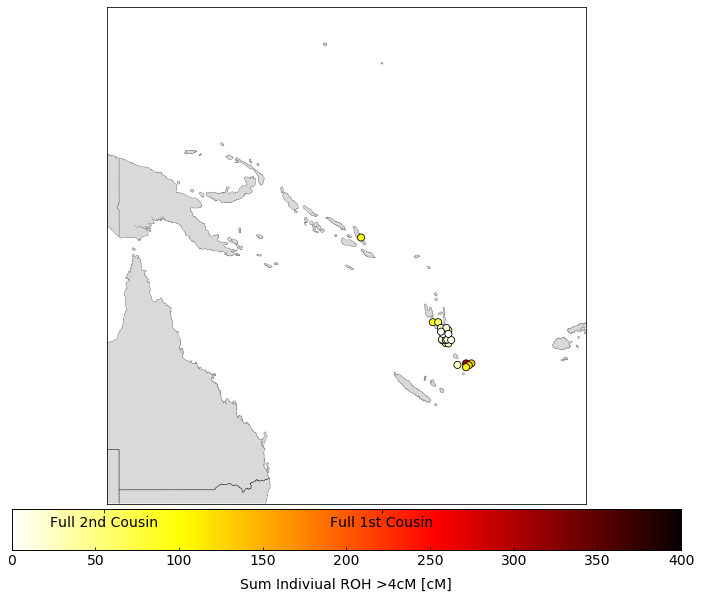

In [8]:
plot_continent(df_plot, crs=[-30, 10, 140, 180], s=50, figsize=(12,10),
               annotate=False, fs_labels=14, ew=0.8)

## Plot Subregion and Subtime

### European HGs:

In [6]:
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_old = extract_df_age(df_euro, 7000, 25000)

In [69]:
substrings = ["HG", "Mesolithic", "Villabruna", "ElMiron", "Bichon", "Loschbour_published"]
hg = df_euro_old["clst"].str.contains('|'.join(substrings))
df_hg = df_euro_old[hg]
#df_hg.sort_values(by="age")[:50]
len(df_hg)

59

Saved to ./figures/poster_probgen19/eur_hg_map.png


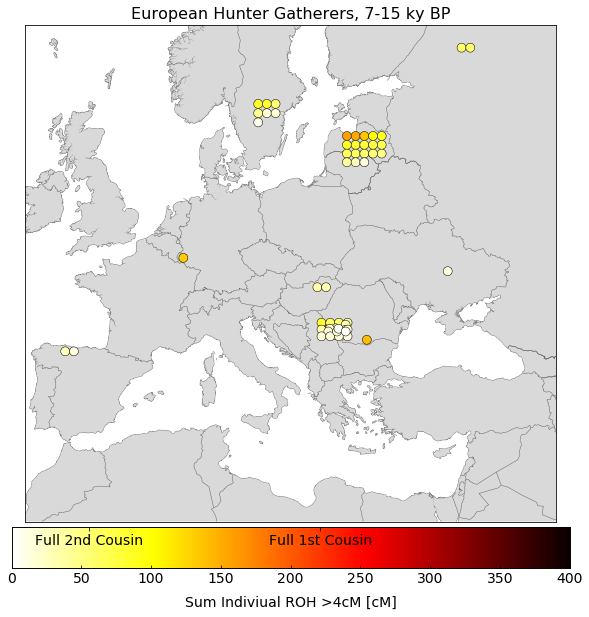

In [90]:
#df_plot = prepare_coordinates_df(df_hg, ofst_lat=0.5, ofst_lon=0.9)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=80, title="European Hunter Gatherers, 7-15 ky BP", fs_labels=16,
               savepath="./figures/poster_probgen19/eur_hg_map.png", figsize=(10,10), dpi=100)
#vrange_a=[7000,15000] , mm=2.7

### Early European Farmers (7ky - 12ky BP)

In [91]:
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_old = extract_df_age(df_euro, 6000, 9000)

substrings = ["N", "farmer"]
neo = df_euro_old["clst"].str.contains('|'.join(substrings))
df_neo = df_euro_old[neo]
len(df_neo)

121

Saved to ./figures/poster_probgen19/eur_eef_map.png


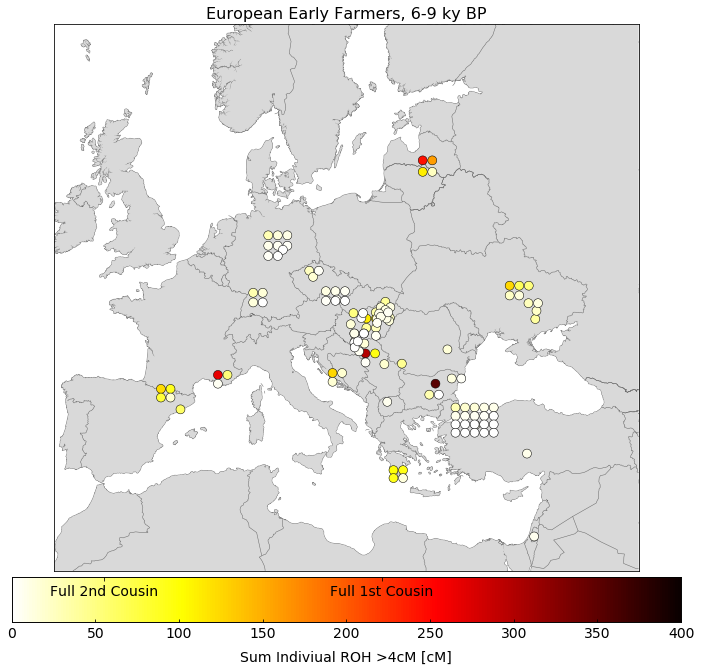

In [93]:
df_plot = prepare_coordinates_df(df_neo, ofst_lat=0.6, ofst_lon=0.9)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=80, title="European Early Farmers, 6-9 ky BP",
              fs_labels=16, savepath="./figures/poster_probgen19/eur_eef_map.png", dpi=100)
#vrange_a=[6000,9000], mm=2.7

### European Bronze Age

In [95]:
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_young = extract_df_age(df_euro, 2800, 6000)

substrings = ["BA", "Beaker", "Mycenaean", "Minoan"]
ba = df_euro_young["clst"].str.contains('|'.join(substrings))

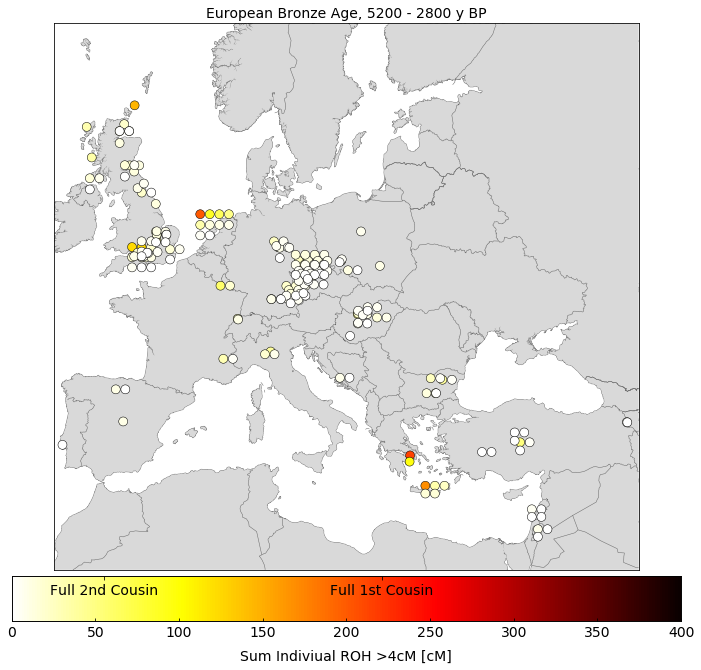

In [97]:
df_plot = prepare_coordinates_df(df_euro_young[ba], ofst_lat=0.6, ofst_lon=0.9)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=80, title="European Bronze Age, 5200 - 2800 y BP", dpi=100)
# vrange_a=[2800,6000], mm=2.7

### European Recent

In [65]:
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_young = extract_df_age(df_euro, 0, 2800)
len(df_euro_young)

99

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


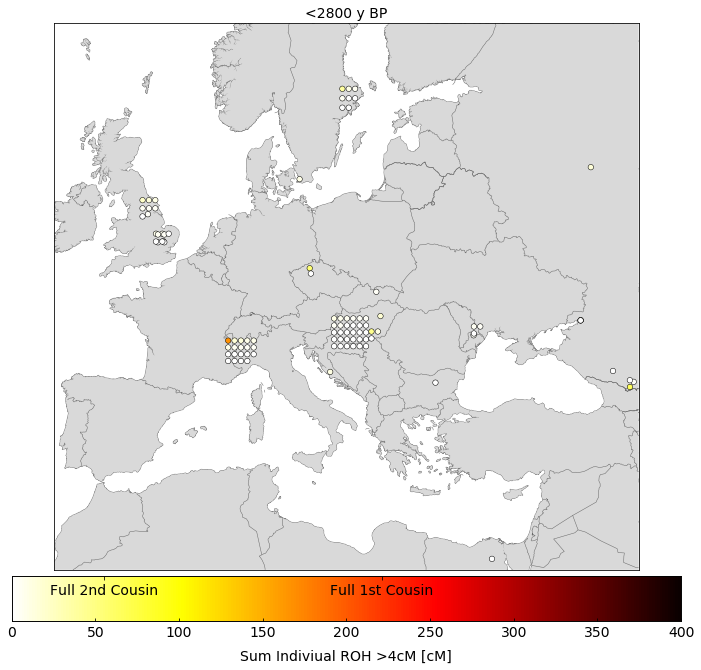

In [66]:
df_plot = prepare_coordinates_df(df_euro_young, ofst_lat=0.45, ofst_lon=0.6)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=30, title="<2800 y BP")  #vrange_a=[0,2800], mm=2.7

### Plot Yamnaya, Corded Ware

In [202]:
#substrings = ["BA", "Beaker", "Mycenaean", "Minoan"]
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_young = extract_df_age(df_euro, 2800, 7000)
substrings = ["Corded_Ware", "CW", "Yamn", "Steppe", "Beaker"]
#substrings = ["Beaker"]
cw = df_euro_young["clst"].str.contains('|'.join(substrings))

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


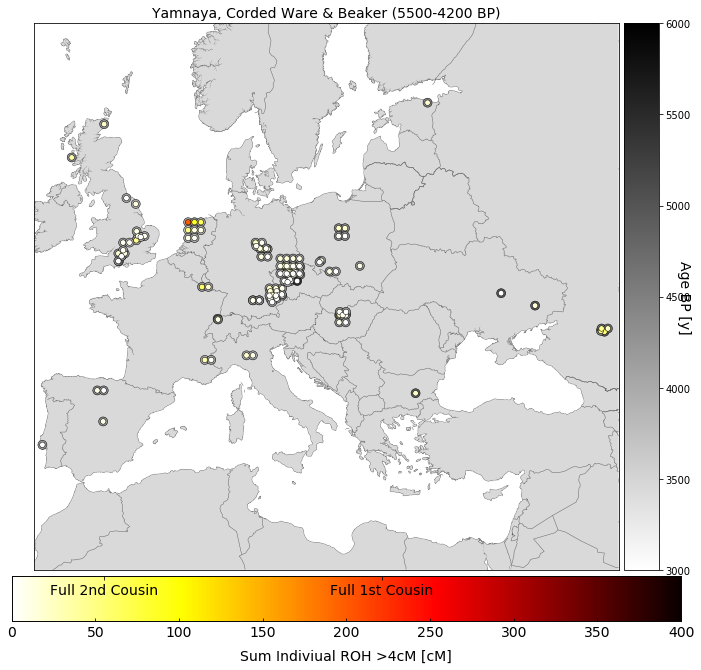

In [203]:
df_plot = prepare_coordinates_df(df_euro_young[cw], ofst_lat=0.45, ofst_lon=0.6)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=30, title="Yamnaya, Corded Ware & Beaker (5500-4200 BP)",vrange_a=[3000,6000], mm=2.7)

# Plot ROH vrs Age
Standalone from here on (besides overall imports and functions in beginning)

In [107]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [15]:
### First load the Data
df1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", '\t')
print(f"Loaded {len(df1)} Individuals")
df1 = clean_roh_df(df1, age_cutoff=14000)

#df_euro = extract_df_geo(df1, 29, 62, -10, 45).copy()  # Make a new Copy. EUrope
df_euro = extract_df_geo(df1, -60, 55, -130, -30).copy()  # Make a new Copy. America
#df_euro = extract_df_geo(df1, 49, 60, -12, 3).copy()  # Make a new Copy. Great Britain

print(f"Extracted {len(df_euro)} European Individuals")
df_euro["color"]="darkgray"

Loaded 1098 Individuals
Filtered to 988 Individuals with existing Lat/Lon values
Filtered to 962 Individuals with Age < 14000
Filtered to 960 unique Individuals
Extracted 68 European Individuals


In [125]:
def lowess_sqrt(x,y, frac=2/3):
    """Do a Lowess fitting on the sqrt"""
    y=np.sqrt(y)
    z = lowess(y, x, frac=frac)
    z[:,1]=z[:,1]**2
    return z

### Do the whole Data
x=df_euro["age"].values
y=df_euro["sum_roh"].values
c=df_euro["color"]
z = lowess_sqrt(x, y)
#w = lowess(y, x, frac=1./3)

### Do the Hunter Gatherers samples
substrings = ["HG", "Mesolithic", "Villabruna", "ElMiron", "Bichon", "Loschbour"]
hg = df_euro["clst"].str.contains('|'.join(substrings))
df_hg = df_euro[hg]
df_hg = df_hg[df_hg["age"]>6000]
print(f"Extracted {len(df_hg)} HGs")

x_hg = df_hg["age"].values
y_hg = df_hg["sum_roh"].values
z_hg = lowess_sqrt(x_hg, y_hg, frac=1)


### Do the EEFs
substrings = ["N", "farmer"]
df_t = extract_df_age(df_euro, 3000, 9000)
neo = df_t["clst"].str.contains('|'.join(substrings))
neth = df_t["clst"].str.startswith("Nether")
df_neo = df_t[neo&(~neth)]
print(f"Extracted {len(df_neo)} Neolithic Individuals")

x_neo = df_neo["age"].values
y_neo = df_neo["sum_roh"].values
z_neo = lowess_sqrt(x_neo, y_neo, frac=1)

### Do BA
df_t = extract_df_age(df_euro, 2800, 7000)
substrings = ["Corded_Ware", "CW", "Yamn", "Steppe", "Beaker"]
#substrings = ["Beaker"]
cw = df_t["clst"].str.contains('|'.join(substrings))
df_b = df_t[cw]
print(f"Extracted {len(df_b)} BA Individuals")

x_b = df_b["age"].values
y_b = df_b["sum_roh"].values
z_b = lowess_sqrt(x_b, y_b, frac=1)

Extracted 0 HGs
Extracted 1 Neolithic Individuals
Extracted 0 BA Individuals


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/harald/.local/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


In [126]:
def plot_lowess_smoothing(savepath="", fs=14, fsl=10, tot_l=3539.39, plot_substruct=True,
                         figsize=(12,6), title="", dpi=300):
    """Plot Lowess Smoothing of ROH vrs Age.
    plot_substruct: Whether to plot the three different periods"""

    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.scatter(x, y, c=c, edgecolor="k", s=30)
    plt.plot(z[:,0], z[:,1], "k-", label=r"Lowess Smoothing ($\sqrt{x}$)", lw=3)

    if plot_substruct:
        ### Do HG
        plt.scatter(x_hg, y_hg, c="red", ec="k", s=30, label="Hunter Gatherer")
        plt.plot(z_hg[:,0], z_hg[:,1], "r-", lw=2)

        ### Do Farmers
        plt.scatter(x_neo, y_neo, c="blue", ec="k", s=30, label="Farmers")
        plt.plot(z_neo[:,0], z_neo[:,1], "b-", lw=2)

        ### Do BA
        plt.scatter(x_b, y_b, c="green", s=30, ec="k", label="Yamnaya/CW/Beaker")
        plt.plot(z_b[:,0], z_b[:,1], "g-", lw=2)


    ### Do the horizontal Lines
    ticks = [tot_l/16, tot_l/64]

    ax.set_ylim([0,800])
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yscale('squareroot')
    ax2.set_yticks(ticks)
    ax2.set_yticklabels(["1st C.", "2nd C."])
    for t in ticks:
        ax.axhline(t, color="gray", lw=0.5, ls="--")
    ax2.tick_params(axis='y', direction='in', labelsize=fsl, pad=5)

    ax.set_xlabel("Age BCE [years]", fontsize=fs)
    ax.set_ylabel("Sum ROH >4 cM [cM]", fontsize=fs)

    ax.invert_xaxis()
    ax.set_yscale('squareroot')
    #plt.ylim([0, 800])

    ax.legend(loc="upper right", fontsize=fsl)
    if len(title)>0:
        ax.set_title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/poster_probgen19/europe_roh_timeseries.png


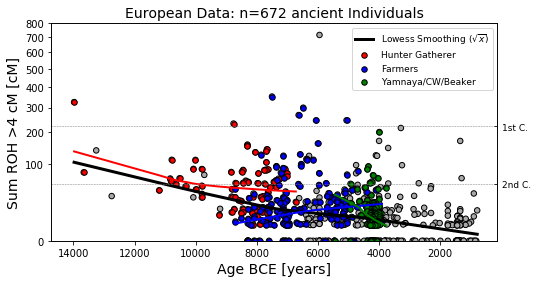

In [121]:
plot_lowess_smoothing(title=f"European Data: n={len(df_euro)} ancient Individuals", figsize=(8,4), fsl=9,
                      savepath="./figures/poster_probgen19/europe_roh_timeseries.png")

Saved to ./figures/poster_probgen19/america_roh_timeseries.png


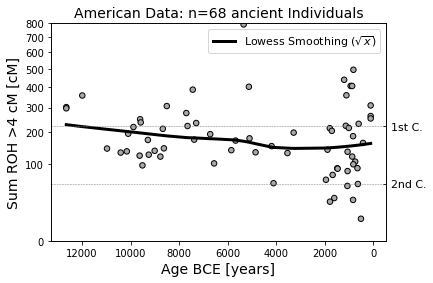

In [127]:
plot_lowess_smoothing(title=f"American Data: n={len(df_euro)} ancient Individuals", figsize=(6,4), fsl=11,
                     savepath="./figures/poster_probgen19/america_roh_timeseries.png", plot_substruct=False)

In [129]:
substrings = ["Stuttgart", "Loschbour"]
hg = df_euro["clst"].str.contains('|'.join(substrings))
df_hg = df_euro[hg]

In [135]:
substrings = ["Loschbour_snpAD.DG","I0001"]
#substrings = ["I0001", "Loschbour_snpAD.DG"]
hg = df_euro["iid"].isin(substrings)
df_hg = df_euro[hg]

### Make Plot of South American vrs Age (maybe contrasting Europe)

# Plot Age of Samples

In [24]:
### Some helper functions to plot the ages of the samples

def plot_map_age(df, crs=[30, 60, -10, 40], s=40, vrange=[0, 7500], cmap="viridis_r", 
                   fs_label=14, figsize=(12,11),
                   states=True, annotate=False, fs_labels=14, ew=0.5, y_off=1, title="", 
                   vrange_a=[], mm=3.1, hspace=0.02,
                   savepath="", dpi=300, cm_min=4, height_ratios=[20,1]): 
    """Plot a continent, based on coordinates in df
    df: Pandas Datframe with lat lon column
    crs: [4], Corners of plot (lat and then lon)
    vrange: Normalization range for color [cM]
    shiftlong: Add to longitude (in cases for map on South America)
    vrange_a: The Age Range to Plot"""
    col_cont, col_lake = "#d9d9d9", "#d9d9d9"  # Colors for Map
    fs = 18
    lon, lat = df["lon"].values, df["lat"].values
    
    colors = df["age"]  ### Plot based on sum roh
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=height_ratios) # Third axis is just to get space!
    ax = plt.subplot(gs[0]) # The upper subplot
    ax1 = plt.subplot(gs[1]) # The lower one
    
    gs.update(wspace=0.0, hspace=hspace) # set the spacing between axes.

    m = Basemap(projection='merc', llcrnrlat=crs[0], urcrnrlat=crs[1],\
                llcrnrlon=crs[2], urcrnrlon=crs[3], resolution='i', ax=ax)  # mill

    m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
    #m.etopo(scale=0.5, alpha=0.4)  # Topological Map
    m.drawcoastlines(color='gray', zorder=0)
    m.drawcountries(color="dimgray")
    
    if states==True:
        m.drawstates()
        
    ### Convert lat/lon to the plot coordinates
    #lon = m.shiftdata(lon, lon_0=0) # Shift Longitudes so that plotted (-180,180 around lon0)
    coords = np.array([m(lon[i],lat[i]) for i in range(len(lon))])
    x,y = np.array(coords[:,0]), np.array(coords[:,1])

    ax.scatter(x, y, c=colors, ec="k", s=s, lw=ew, cmap=cmap, norm=norm, zorder=3)
    
    if annotate:
        for i, txt in enumerate(df["iid"]):
            ax.text(x[i], y[i]+y_off, txt, fontsize=fs_labels, zorder=1, ha="center", clip_on=True)
    
    if len(title)>0:
        ax.set_title(title, fontsize=fs_labels)
    
    # Do the colorbar
    plot_colorbar_age(ax1, fs_label=fs_label, cmap=cmap, norm=norm)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    plt.show()
    
    
def plot_colorbar_age(ax1, fs_label, cmap, norm):
    """Code for plotting the colorbar"""
    cb1 = clb.ColorbarBase(ax1, cmap=cmap,
                           norm=norm, orientation='horizontal') # For the /1e3 format
    cb1.ax.tick_params(axis='x', direction='in', labelsize=fs_label)
    ax1.set_xlabel('Age [years BP]', fontsize=fs_label, rotation=0, labelpad=10)

def give_df_clsts(df, search=[], col="pop"):
    """Return sub dataframe within df
    where in col one of search strings (list of string)"""
    idx = df[col].str.contains('|'.join(search)) # Find
    return df[idx]

def extract_sub_df_geo_kw(df, lat0, lat1, lon0, lon1, keywords=[]):
    """Extract Dataframe df from Sub Data frame based on coordinates
    AND from keywords
    lat0,lat1: Min and Max Lat. Equ. for lon0,lon1"""
    df1 = extract_df_geo(df, lat0, lat1, lon0, lon1).copy()  # Make a new Copy. America
    df2 = give_df_clsts(df, search=keywords) 
    df_m = pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)
    print(f"Found {len(df_m)} Individuals; {len(df1)} from Geography")
    return df_m

## Plot Iberia Age Map [Paper]

In [59]:
df_1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_2 = pd.read_csv("./Empirical/Eigenstrat/Olalde19/combined_roh05.csv", sep="\t")
df_c = pd.concat([df_1, df_2], ignore_index=True, sort=True).sort_values(by="sum_roh>4", ascending=False)
df_iberia = extract_sub_df_geo_kw(df_c,  35.95, 44, -10, 4, keywords = ["Iberia", "Portugal", "Spain"])
df_iberia = extract_df_age(df_iberia, 0, 15000)

df_plot = prepare_coordinates_df(df_iberia, ofst_lat=0.2, ofst_lon=0.27)

Found 136 Individuals; 118 from Geography


/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Saved to ./figures/manuscript/timelines/iberia_map.pdf


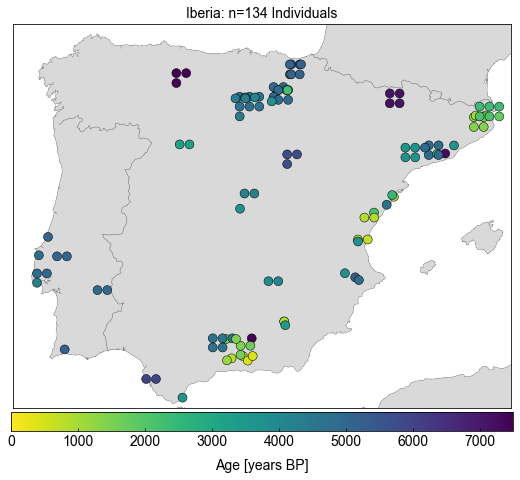

In [60]:
plot_map_age(df_plot, crs=[35.9, 44, -10, 3.7], s=80, figsize=(9, 7.5), 
             vrange=[7500,0], states=False, title=f"Iberia: n={len(df_plot)} Individuals", 
             savepath="./figures/manuscript/timelines/iberia_map.pdf")

## Plot Italy Age Map [Paper]
Pot Samples from Antonio et al. 2019

In [61]:
df1 = pd.read_csv("./Empirical/1240k/Antonio/combined_roh05.csv", sep="\t")
df_plot = prepare_coordinates_df(df1, ofst_lat=0.25, ofst_lon=0.29)

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Saved to ./figures/manuscript/timelines/italy_map.pdf


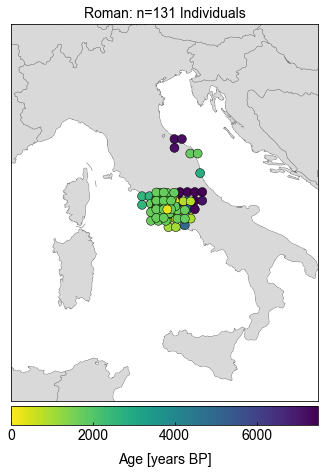

In [62]:
plot_map_age(df_plot, crs=[36, 47, 6.5, 18.5], s=80, figsize=(5.5, 7.4), 
             vrange=[7500,0], states=False, title=f"Roman: n={len(df_plot)} Individuals",
             savepath="./figures/manuscript/timelines/italy_map.pdf")

# Area 51
Test Code here 

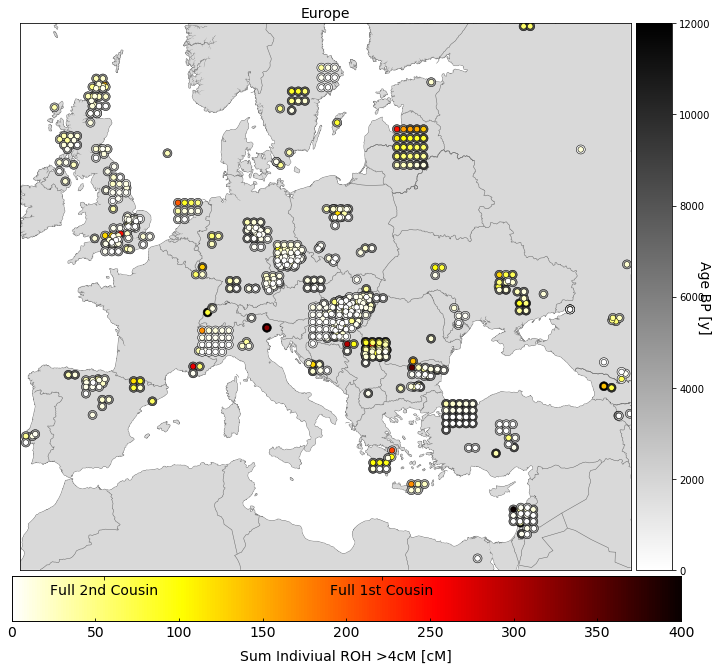

In [220]:
#df_plot = prepare_coordinates_df(df_euro, ofst_lat=0.45, ofst_lon=0.6)
#plot_continent(df_plot, crs=[49, 60, -12, 3], s=30, title="Great Britain",vrange_a=[0,9000], mm=2.7)
plot_continent(df_plot, crs=[29, 62, -10, 45], s=30, title="Europe", vrange_a=[0,12000], mm=2.7)


# Make South America (Plot for Poster Probgen)

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Saved to ./figures/poster_probgen19/sa_roh.pdf


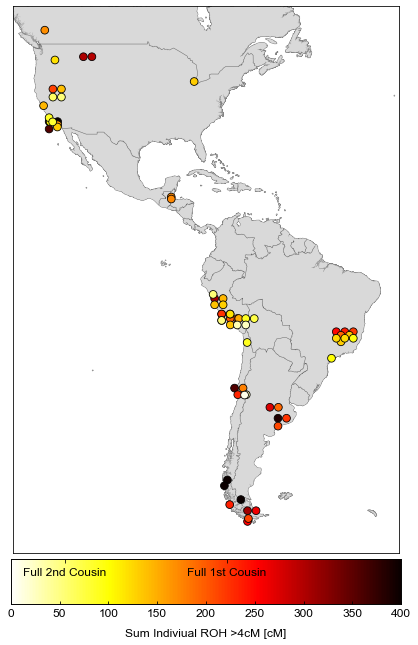

In [21]:
df_plot = prepare_coordinates_df(df1, ofst_lat=1.6, ofst_lon=2.2)  # Spacing adequate for whole America
plot_continent(df_plot, crs=[-60, 55, -130, -30], s=60, figsize=(7, 11), states=False,
               annotate=False, fs_label=12, ew=0.8, savepath="./figures/poster_probgen19/sa_roh.pdf") # vrange_a=[0,10000], mm=2.7

In [20]:
df_plot.loc[df_plot["iid"]=="Aconcagua.SG","lat"] # Should be -32.65

683   -32.65
Name: lat, dtype: float64

In [172]:
#substrings = ["BA", "Beaker", "Mycenaean", "Minoan"]
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_young = extract_df_age(df_euro, 2800, 7000)
substrings = ["Corded_Ware", "CW", "Yamn", "Steppe"]
cw = df_euro_young["clst"].str.contains('|'.join(substrings))

In [ ]:
df_plot = prepare_coordinates_df(df_euro_young, ofst_lat=0.45, ofst_lon=0.6)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=50, title="<2800 y BP")

In [16]:
df_sa = extract_df_geo(df1, -90, 90, -150, -30)
df_sa = extract_df_age(df_sa, 0, 1000)

In [17]:
df_sa["study"].value_counts()
len(df_sa)

PosthNakatsukaCell2018    7
RaghavanScience2015       3
ScheibScience2018         3
MorenoMayarScience2018    2
delaFuentePNAS2018        1
Name: study, dtype: int64

In [3]:
df1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", '\t')
print(f"Loaded {len(df1)} Individuals")

Loaded 1098 Individuals
